In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
import tensorflow
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re

from bs4 import BeautifulSoup
# import plotly.graph_objs as go
# import plotly.plotly as py
# import cufflinks
from IPython.core.interactiveshell import InteractiveShell
# import plotly.figure_factory as ff
# InteractiveShell.ast_node_interactivity = 'all'
# from plotly.offline import iplot
# cufflinks.go_offline()
# cufflinks.set_config_file(world_readable=True, theme='pearl')

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = "/content/gdrive/My Drive/Tip_Travel_BinhThuan/"
fn_path = path + "new_final_text.csv"
df = pd.read_csv(fn_path)
df = df[['new_feature','Category']]


In [0]:
df.Category = df.Category.map(lambda x: "song-khoe" if x == "suc-khoe-y-khoa" else x)


In [18]:
labels =  ['song-khoe','nhac-pop','bat-dong-san','giao-duc','thoi-su']
arr_df = []
for label in labels :
  print (label)
  tmp_df = df[df.Category == label]
  arr_df.append(tmp_df)
new_df = pd.concat(arr_df)

song-khoe
nhac-pop
bat-dong-san
giao-duc
thoi-su


In [37]:
cates = new_df.groupby('Category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 5
Category
bat-dong-san    2328
giao-duc        2001
nhac-pop        3628
song-khoe       3430
thoi-su         2001
dtype: int64


In [19]:

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~', lower=True)
tokenizer.fit_on_texts(new_df['new_feature'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 64742 unique tokens.


In [20]:

X = tokenizer.texts_to_sequences(new_df['new_feature'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (13388, 250)


In [21]:

Y = pd.get_dummies(new_df['Category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (13388, 5)


In [22]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(12049, 250) (12049, 5)
(1339, 250) (1339, 5)


In [25]:

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10844 samples, validate on 1205 samples
Epoch 1/5
10844/10844 [==============================] - 94s 9ms/step - loss: 0.7678 - acc: 0.6834 - val_loss: 0.3174 - val_acc: 0.9087
Epoch 2/5
10844/10844 [==============================] - 94s 9ms/step - loss: 0.1992 - acc: 0.9418 - val_loss: 0.1060 - val_acc: 0.9710
Epoch 3/5
10844/10844 [==============================] - 93s 9ms/step - loss: 0.0898 - acc: 0.9745 - val_loss: 0.1252 - val_acc: 0.9635
Epoch 4/5
10844/10844 [==============================] - 93s 9ms/step - loss: 0.0440 - acc: 0.9899 - val_loss: 0.0923 - val_acc: 0.9734
Epoch 5/5
10844/10844 [==============================] - 94s 9ms/step - loss: 0.0468 - acc: 0.9876 - val_loss: 0.1068 - val_acc: 0.9676


In [27]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1339/1339 [==============================] - 3s 2ms/step
Test set
  Loss: 0.103
  Accuracy: 0.972


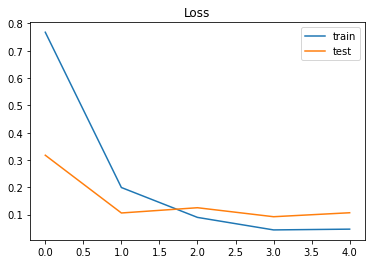

In [28]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

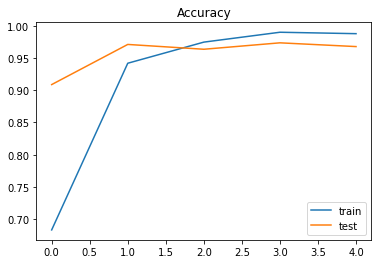

In [29]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();
